# Comparando métodos de alocación con backtrader

### Estrategia Pasiva o Activa?

Podemos elegir entre una buena variedad de estrategias pasivas de alocación de activos como la clásica 60%/40%, la Cartera Permanente de Harry Browne, o la All Weather de Ray Dalio, que apuntan a que la mediante la diversificación estratégica, se reduzca el riesgo y se minimize los drawdowns. Operativamente son carteras muy sencillas de gestionar, se eligen los ETFs que representan las estrategias, se invierte, y una vez por año se rebalancea. Si está interesado en la Cartera Permanente, puede comprar PRPFX y hasta se lo rebalancean por usted! 

Existen por otro lado los sistemas de alocación más activos, podemos englobar ahí toda la familia de Tactical Asset Allocation (TAA). En el pasado se los conocían como sistemas de market timing, pero como han tenido mala fama, han tomado este mejor nombre mucho más moderno. Ignacio y Rafael se encargaron de demostrar aquí mismo algo que había investigado por mi cuenta: que los retornos de estos sistemas dependen de la suerte en la temporalidad del rebalanceo.

En febrero 2020, un portfolio de rebalanceo trimestral (y hasta uno mensual dependiendo del día del mes que le tocaba rebalancear) no tenía como enterarse que había una pandemia ahí afuera, pero uno que mira su cuenta de capital no le era indiferente esa coyuntura mundial. En mi caso, sobreviviente de las infinitas devaluaciones argentinas y doliente del escenario del 2008, pude salir airoso de esta caída y mantener el valor de mi cartera mientras sucedía la recuperación. ¡Qué me van a venir con eso de la diversificación mientras los mercados diariamente caían 4%!

### Keep it simple

Durante este artículo vamos a comparar una estrategia de alocación estática contra otra dinámica, utilizando la misma serie temporal y por supuesto los mismos activos. Esta más que comprobado que una buena cartera debe contener activos de baja correlación, los modelos más simples de portfolios estáticos contienen una porción bonos y otra mayor en acciones que históricamente cumplen esta condición. 

Estos modelos clásicos usan ETFs que representan una amplia diversificación del universo de stocks (como VT, VTI o ITOT), son portfolios de los más rentables en los últimos 5 años pero que tienen un alto drawdown comparado con estrategias de mayor diversificación del riesgo. Pero si tenemos un modelo muy activo que busque protegernos de eventos inesperados del mercado, podriamos considerar entonces un activo de mayor riesgo, de mayor volatilidad y mayor retorno para representar a las acciones. Es por eso que si bien mantendremos el clásico TLT para representar los bonos, para representar a los activos accionarios utilizaremos el ETF del índice estrella Nasdaq mediante QQQ.

Podemos ver debajo que la correlación entre ambos ETFs cambia en el tiempo pero mantiene el comportamiento negativo entre ambos activos.

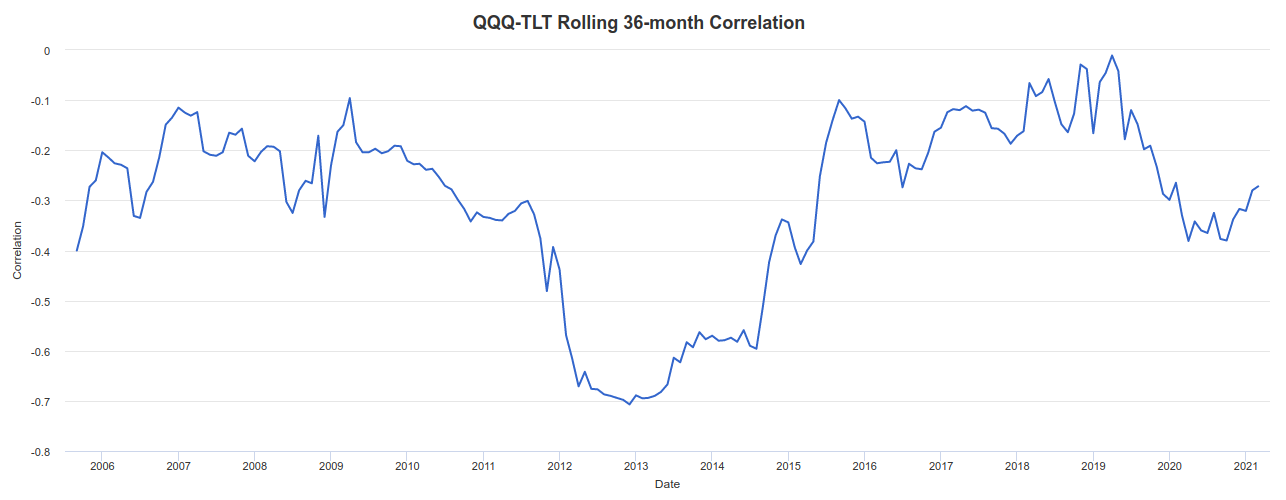

El lector luego puede replicar este modelo para elegir cualquier par de activos que mejor represente su cartera, su geografia o su apetito de riesgo como inversor.

Importante destacar que este no será sólo un artículo conceptual sino que mostraremos su implementación en python, apalancando el uso de la librería backtrader para mostrar en forma práctica un framework de trabajo para el desarrollo de estrategias de asset allocation y trading algorítmico .

### Backtrader o backtrader

Esta no será una publicación para explicar en detalle la libreria backtrader pero si uno que debe ser considerado como un agradecimiento al trabajo de Daniel Rodriguez, la desactivación de Quantopian (los que estaban detras de zipline y pyfolio) pone hoy aun mas en valor este tremendo proyecto.

Backtrader tiene todo lo que se requiere para hacer un backtesting, y aún mas. La libreria se encuentra excelentemente documentada (https://www.backtrader.com/), con su respectivo repositorio y esta soportada por una activa comunidad de usuarios, colaboradores y entusiastas.

Vamos a intentar que todo este ejemplo sea simple, usando solamente backtrader para todo el ejercicio, para asi poder demostrar las potentes capacidades que nos permite esta libreria.

In [77]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime
import backtrader as bt

### Preparemos nuestro cerebro

Para iniciar backtrader, necesitamos inicializar una instancia de cerebro (así llamo Daniel a la clase principal de backtrader) y definir los parámetros principales del broker, el capital inicial de la estrategia y el esquema de  comisiones de las operaciones.  

Asumimos que vamos a trabajar con ETFs en brokers americanos donde hoy no tenemos cargos por transacción, lo que hace que este tipo de estrategias sean accesibles implementar. Históricamente las estrategias activas no se desempeñaban mejor que las pasivas cuando se les incorporaban los costes de operación, y ese supuesto sigue rondando en muchos inversores: "no se gana dinero con el market timming". 

El siguiente paso será de hacernos de la data Yahoo de los ETFs con los cuales vamos a ejecutar la estrategia. Y si, backtrader tiene una integración directa con este proveedor de datos y otros más, así como la capacidad de incorporar fuentes propias de datos en archivos .csv o en pandas.

Finalmente debemos establecer que instrumentación vamos a requerir para medir el desempeño de cada estrategia, para ello utilizaremos los Observers y Analyzers de backtrader. Para este ejemplo utilizaremos los provistos por backtrader pero es posible extender estos objetos para implementar los que uno requiera.

Durante la ejecución, estos indicadores van recolectando la información que luego utilizaremos para medir el desempeño de cada estrategia o para mostrar en el gráfico que presentaremos con la ejecución del backtesting.

In [78]:
def backtest(strategy, equity=100000, symbols=[], 
                 fromdate=datetime(2010, 1, 1), todate=datetime(2020, 12, 31),
                 plot=False, **kwargs):
    
    # en esta funcion consolidaremos la inicializacion del objeto, del broker, la data y los indicadores,
    # ejecutaremos la estrategia, la graficaremos y finalmente retornaremos los resultados de la misma
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(equity) # capital inicial
    cerebro.broker.setcommission(commission=0.0) # sin comisiones
    cerebro.broker.set_coc(True) # nos permitira trabajar con datos EOD
    #cerebro.broker.set_checksubmit(checksubmit=False)
    #cerebro.addsizer(bt.sizers.PercentSizer, percents=99) # tamaño de la order por defecto
    
    for symbol in symbols: # par de simbolos que utilizaremos
        # obtenemos las series OHLCV de frecuencia diaria para la ventana de tiempo indicada
        data = bt.feeds.YahooFinanceData(dataname=symbol,
                                  fromdate=fromdate,
                                  todate=todate )
        cerebro.adddata(data)
    
    # estos observers nos permite visualizar la cuenta de capital y el drawdown en el grafico
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    # este observer marcará las operaciones sobre cada activo
    cerebro.addobservermulti(bt.observers.BuySell)
    
    # los resultados de estos analyzers los consultaremos luego de la ejecución    
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, annualize=True)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    
    # preparamos la estrategia a ejecutar y le pasamos los parámetros    
    cerebro.addstrategy(strategy, **kwargs)
    # GO!
    results = cerebro.run(stdstats=False) 
    
    # graficamos la estrategia, ademas de los assets se muestran los observers definidos
    # la funcion plot ofrece opciones de personalización del gráfico que puede ser ademas implementadas 
    # a nivel de objeto, indicadores o dentro de la estrategia misma
    if plot:
        import matplotlib.pyplot as plt
        plt.rcParams["figure.figsize"] = (12, 6) # (w, h)
        cerebro.plot( 
                iplot=True, volume=False, fmt_x_ticks = '%Y/%m/%d',
                start=0, rowsmajor=3, rowsminor=3, )

    # devolvemos el valor final de la cuenta en el broker 
    # y los distintos analyzers para compararlo luego    
    return  "{:.2f}".format(cerebro.broker.getvalue()), \
            "{:.2f}".format(results[0].analyzers.returns.get_analysis()['rnorm100']), \
            "{:.2f}".format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']), \
            "{:.2f}".format(results[0].analyzers.drawdown.get_analysis()['max']['drawdown'])

### A esto le falta clase

Durante este ejemplo desarrollaremos dos estrategias que ejecutaremos con los mismos activos en el mismo periodo de tiempo.

La estrategia FixedAllocation contendrá la lógica para implementar nuestro benchmark: un estrategia clásica 60/40.
Mientras en la estrategia DynamicAllocation utilizaremos un método de alocación dinámica utilizando Dual Momentum entre los dos activos.

La lógica de cualquier estrategia en backtrader se desarrolla dentro de una clase de tipo Strategy. La implementación de cada estrategia requiere la definición de parámetros y métodos predefinidos siendo los más importantes init y next. El primero se ejecuta al inicio de la serie temporal, el segundo en cada una de las barras de tiempo definidas, que para este caso será en forma diaria ya que utilizaremos datos EOD.

La primera clase definirá la estrategia clásica de alocación estática, donde se realiza la inversión al primer dia según la distribución definida para cada activo, y se cierran las posiciones al último día para evaluar el desempeño de la estrategia. 

In [79]:
class FixedAllocation(bt.Strategy):
    # definimos la alocacion fija donde se alocara 60% al primer asset y 40% al segundo
    # sin embargo el parametro que se utilizara es que el se utilize cuando se crea la instancia
    # al momento de la ejecucion, sino se invoca con ningun parametro se utiliza este parametro default
    params = dict( percent=0.6, )

    def __init__(self):
        pass
        
    # el primer dia de backtest ponemos las ordenes para cada asset como porcentaje del total de la cartera
    # el metodo nextstart se ejecuta antes del primer dia
    def nextstart(self):     
        # lista con los pesos para cada activo
        weights = [self.p.percent, 1 - self.p.percent ]
                
        # para referencias las series temporales de los activos utilizamos self.datas
        # self.data0 es el primer activo cargado, en este caso QQQ
        # si quisieramos acceder a TLT utilizariamos self.data1
        for i, d in enumerate(self.datas):
            # target percent es uno de los tipos de ordenes que provee bracktrader
            self.order = self.order_target_percent(d, target=weights[i])
            weight_str = str('{:.0%}'.format(weights[i]))
            date_text = d.datetime.date(0).isoformat()
            print(date_text + " BUY " + d._name + ": " + weight_str )

    def next(self):
        # llega al ultimo dia del backtest y ahi ....
        if len(self.data0) == self.data0.buflen() - 1:
            date_text = self.data0.datetime.date(0).isoformat()
            for i, d in enumerate(self.datas):
                # cerramos las posiciones para generar las estadisticas
                self.close(d, exectype=bt.Order.Market)
                print(date_text + " CLOSE " + d._name  )


Para la estrategia dinámica de tipo TAA, vamos a evaluar todos los dias el potencial rebalanceo, o sea que estaremos mirando en cada punto del tiempo los indicadores definidos utilizando los conceptos de Dual Momentum para tomar una decisión de cambio de activo. Aqui nos apartamos de los sistemas en donde se elige un punto en el tiempo en donde realizar el rebalanceo (mensual, trimestral, anual, etc.), sino que el sistema estará diariamente evaluando las condiciones de los indicadores para hacer el cambio entre los activos.

Vamos a continuar siendo simples, utilizaremos los mismos dos activos de baja correlación y el rebalanceo será del 100% del capital entre un activo y el otro.

In [80]:
class DynamicAllocation(bt.Strategy):
    
    # aqui tenemos los parametros por default especificos para esta estrategia, los podemos invocar
    # dentro de los mtodos de la clase mediante self.p.parametro o self.params.parametro
    params = dict( dif=20, fast=5, slow=20, alloc=1, )
        
    def __init__(self):
        #self.data0.plotinfo.plot = False
        #self.data1.plotinfo.plot = False
        
        # primero vamos a definir la lógica para evaluar el CrossSectional Momentum o Momentum Relativo
        # utilizaremos un concepto sencillo como las diferencias de los rendimientos diarios como spread
        # si es positivo es porque el primer activo rinde mas que el segundo
        # y si es menor a cero sera que nos conviene por rendimientos relativos estar invertido en el segundo.
        self.roc_data0 = bt.indicators.ROC(self.data0.close, period=1, plot=False)
        self.roc_data1 = bt.indicators.ROC(self.data1.close, period=1, plot=False)
        self.difroc = (self.roc_data0 - self.roc_data1)
        
        # procedemos a suavizar la diferencia con una funcion de media movil
        # el argumento subplot=True nos permitira graficarla posteriormente
        self.dif = bt.indicators.SMA(self.difroc, period=self.p.dif, 
                                     plotname="DifROC", subplot=False)
      
        # para las señales creamos indicadores de entrada y de salida cuando cruce la linea del 0
        self.crossDIFBuy = bt.indicators.CrossUp(self.dif, bt.LineNum(0), 
                                                 plotname="DifBuy", plot=False)
        self.crossDIFSell = bt.indicators.CrossDown(self.dif, bt.LineNum(0), 
                                                    plotname="DifSell", plot=False)
        
        # luego, vamos a definir una funcion de Momentum Absoluto para el activo principal de mayor riesgo
        # por un cruce sencillo de dobles medias, asi que definimos una SMA rapida y otra lenta
        self.data0_fast = bt.indicators.SMA(self.data0.close, period=self.p.fast, plotname="FastMA", plot=False)
        self.data0_slow = bt.indicators.SMA(self.data0.close, period=self.p.slow, plotname="SlowMA", plot=False)
 
        # luego tenemos la señal de compra...
        self.crossMABuy = bt.indicators.CrossUp(self.data0_fast, self.data0_slow, 
                                                plotname="CrossOverBuy", plot=False)
        # y la señal de venta dependiendo de la dirección del cruce
        self.crossMASell = bt.indicators.CrossDown(self.data0_fast, self.data0_slow, 
                                                   plotname="CrossOverSell", plot=False)

    def log(self, txt):
        # para esta estrategia implementamos un metodo de logging para hacer seguimiento de cada posicion
        print('{} {}'.format(self.datetime.date(), txt))
        
    def nextstart(self):
        # iniciamos arbitrariamente la ejecucón eligiendo una posicion, 
        # en este caso con todo el capital invertido en el activo de menor riesgo 
        self.asset_in = self.data1._name
        self.order = self.order_target_percent(self.data1, target=1)
        self.log("BUY  " + self.asset_in)
            
    def next(self):
        #print(self.broker.get_cash())

        # esta sera la condición para cambio desde el activo de mayor riesgo al de menor riesgo
        if self.asset_in == self.data0._name: 
            if (self.crossDIFSell[0] > 0 or self.crossMASell[0] > 0):
                self.order = self.order_target_percent(self.data0, target=1 - self.p.alloc)
                self.asset_in = "BUY:" + self.data1._name
                #self.log("BUY  " + self.asset_in)
                return
        
        # esta sera la condición para cambio desde el activo de menos riesgo al de mayor riesgo
        if self.asset_in == self.data1._name:
            if ( self.crossDIFBuy[0] > 0 or self.crossMABuy[0] > 0): # 
                self.order = self.order_target_percent(self.data1, target=1 - self.p.alloc)
                self.asset_in = "BUY:" + self.data0._name
                #self.log("BUY  " + self.asset_in)
                return
        
        # procedemos al cambio de activo
        for dbuy in self.datas:
            if self.asset_in == "BUY:" + dbuy._name:          
                self.order = self.order_target_percent(dbuy, target=self.p.alloc)
                self.asset_in = dbuy._name
                #self.log("BUY  " + self.asset_in)
                return
            
        # igual que en la estrategia anterior, cuando llega al ultimo dia del backtest
        if len(self.data0) == self.data0.buflen() - 1:
            for i, d in enumerate(self.datas):
                # cerramos las posiciones para generar las estadisticas
                self.close(d, exectype=bt.Order.Market)
                self.log("CLOSE " + d._name  )

## Showtime! 

### Alocación estática

Veamos los resultados de la ejecución de la estrategia FixedAllocation con este par de ETFs durante los últimos 5 años.

In [81]:
if __name__ == '__main__':
    
    # inicializamos los parámetros que enviaremos a la función backtest definida
    equity = 100000
    symbols = ['QQQ', 'TLT']
    fromdate = datetime(2016, 1, 1)
    todate = datetime(2020, 12, 31)
    value, cagr, sharpe, drawdown = backtest(FixedAllocation, percent=0.6, 
                                             equity=equity, plot=False,
                                             symbols=symbols, fromdate=fromdate, todate=todate, ) 
    # guardamos los resultados
    stats = [["Estrategia", "Inicial", "Final", "CAGR", "Sharpe", "MaxDrawdown"]]
    stats.append(["FixedAllocation", equity, value, cagr, sharpe, drawdown])

2016-01-04 BUY QQQ: 60%
2016-01-04 BUY TLT: 40%
2020-12-29 CLOSE QQQ
2020-12-29 CLOSE TLT


### Alocación dinámica

Ahora ejecutemos la estrategia DynamicAllocation con los parámetros requeridos para definir el CrossSectional Momentum (dif), el Absolut Momentum (fast y slow) y el porcentaje de alocacion en cada cambio (alloc, que para este ejemplo utilizaremos 1, o sea el 100%). Estos parámetros que estamos utilizando luego se pueden optimizar y ajustar según los activos utilizados en la estrategia.

Si bien no he ejecutado un proceso de optimización sobre los parámetros, importante notar que los mismos representan ventanas temporales mucho menores a las utilizadas en las estrategias de alocación de Dual Momentum que tipicamente conocemos donde se evaluan retornos trimestrales o anuales.

2016-02-02 BUY  TLT
2020-12-29 CLOSE QQQ
2020-12-29 CLOSE TLT


<IPython.core.display.Javascript object>


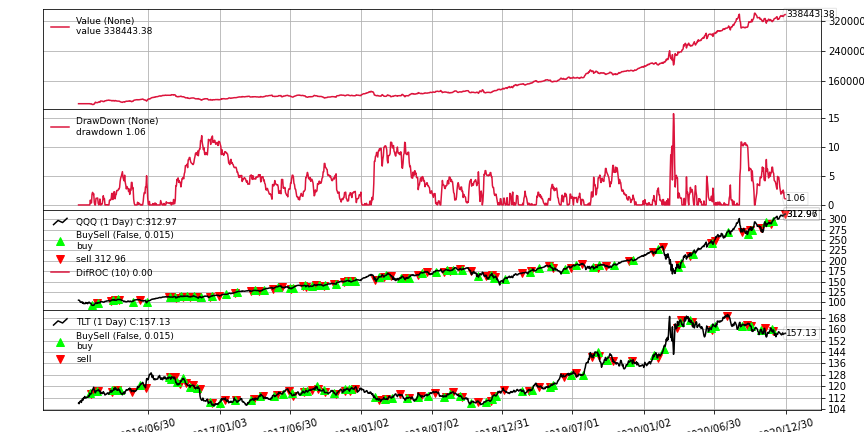

In [82]:
    # volvemos a ejecutar el backtest con la estrategia DynamicAllocation y sus parámetros 
    value, cagr, sharpe, drawdown = backtest(DynamicAllocation, dif=10, fast=5, slow=20, alloc=1,
                                             equity=equity, plot=True,
                                             symbols=symbols, fromdate=fromdate, todate=todate,) 
    # guardamos los resultados
    stats.append(["DynamicAllocation", equity, value, cagr, sharpe, drawdown])

## Clásico vs Moderno

Es hora de comparar los resultados de ambas estrategias. And the winner is...

In [83]:
# mostramos los resultados de ambas estrategias
row_format = "{:<18}" + "{:<12}" * (len(stats[0])-1)
for row in stats:
    print(row_format.format(*row))

Estrategia        Inicial     Final       CAGR        Sharpe      MaxDrawdown 
FixedAllocation   100000      236718.18   18.84       1.32        18.46       
DynamicAllocation 100000      338443.38   27.66       1.24        15.72       


Efectivamente el portfolio dinámico supera en rendimiento anual al estático por casi un 50%, y con unos puntos menos de drawdown. Este comportamiento lo vamos a podemos ver en un sinúmeros de pares de activos los ultimos 5 años, el lector curioso podrá utilizar otros activos y podrá comprobarlo por su cuenta.

Sin embargo no es algo que podamos replicar tan fácilmente (por ejemplo, desde 2010 a 2016), esto es debido al ciclo actual de los mercados (pandemia mediante) que estamos atravesando. Este es un ejemplo más que las estrategias, sobre todos las dinámicas de este tipo, tienen un ciclo de vida donde ya nos crean más esa ventaja, porque la anomalía que explotan ha desaparecido.

A largo plazo, las alocaciones estáticas tendrán una funcion de creación de valor en la cartera total, mientras las alocaciones dinámicas podrán aprovechar oportunidades de rentablidad en el total de la cartera. Más que competencia entre los modelos seguimos incorporando diversificación para mejorar la secuencia de retornos del portfolio.

Desde el punto de vista de la implementación, existen varios parámetros para optimizar el modelo, asi como la posibilidad de seguir explorando sobre los indicadores de Dual Momentum que he implementado en este caso para la estrategia dinámica, especialmente en la definición utilizada en el concepto de spread en ambos activos.
Y si bien hemos eliminado el rebalanceo y con ellos el elemento de suerte, debemos aún considerar que persiste el riesgo de especificación presente en este modelo.

### Comentarios finales

Al tener el código disponible listo para ser ejecutado, el lector podrá rápidamente adaptar el mismo a sus necesidades y curiosidades, claramente el DynamicAllocation dependerá de los párametros para que funcione mejor que el modelo Static, pudiendo alterar los activos considerados, las medias, el porcentaje de alocación y la definición de spread de diferencia de rendimiento, entre otros.

Desde el punto de vista de implementación hemos podido desarrollar todo el ejercicio en backtrader, los escenarios de uso son aun más amplios, ya que no hemos cubierto cryptos, day trading, machine learning, live trading y más.

Principalmente la libreria nos permite enfocarnos en la definción de las estategias más que en el desarrollo de la infraestructura donde se ejecutarán las mismas, aliviando la carga del desarrollador quant.

Si tienen consultas o comentarios, me pueden encontrar en twitter como @marianovolpedo 